In [1]:
%load_ext autoreload
%autoreload 2
%cd ../../
# %pwd
# should be <ROOT>/code/

/home/oli/Research/Joe/agent-goals/code


In [2]:
import numpy as np

from pdg.pdg import PDG
from pdg.rv import Variable as Var, Unit
from pdg.dist import RawJointDist as RJD, CPT

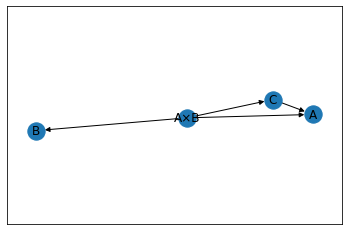

In [7]:
A = Var.alph("A", 3)
B = Var.alph("B", 2)
C = Var.alph("C", 3)

M = PDG()
M += A,B,C

M += CPT.make_random(A&B, C)
M += CPT.make_random(C, A)

M.draw()

In [8]:
best = M.optimize_score(0)
M.score(best, gamma=0)

0.03448150093190291

# IMPLEMENTATION SCRATCH

### **Warmup:** no marginalization or conditioning; $p$ same shape as $\mu$.

In [292]:
M.dshape
n = np.prod(M.dshape)

mu = cp.Variable(n, nonneg=True)
p_special = best.data.reshape(-1)
t = cp.Variable(n)
        -1

tol_constraints = [
#         cp.constraints.exponential.ExpCone(-t[L], mu, fix(p).reshape(-1)) 
        cp.constraints.exponential.ExpCone(-t, mu, p_special) 
    ]


prob = cp.Problem( cp.Minimize( sum(t) ), 
                  [ sum(mu) == 1 ] + tol_constraints )


In [293]:
prob.solve()

2.269466271616548e-09

In [287]:
## Printing stuff for debugging
# for L,X,Y,p in M.edges("l,X,Y,P"):
#     if 'π' not in L: 
#         print(X.name, Y.name, L, p.shape,  μ._idxs(X), μ._idxs(Y))
#         print(p.to_numpy().size)
#         print('yo', mk_projector(M.dshape, μ._idxs(X,Y)).shape)

mu = cp.Variable(np.prod(M.dshape), nonneg=True)
p_special = best.data.reshape(-1)

t = { L : cp.Variable(p.to_numpy().size) for (L,p) in M.edges("l,P") if 'π' not in L }
        
        
tol_constraints = [
#         cp.constraints.exponential.ExpCone(-t[L], mu, fix(p).reshape(-1)) 
        cp.constraints.exponential.ExpCone(-t[L],
#                                            mk_projector(M.dshape, μ._idxs(X,Y))@mu,
                                           mu.T @ mk_projector(M.dshape, μ._idxs(X,Y)),
                                           p.to_numpy().reshape(-1))
            for L,X,Y,p in M.edges("l,X,Y,P") if 'π' not in L
    ]


(3, 2, 3) [0, 1, 2]
(3, 2, 3) [2, 0]


In [288]:
prob = cp.Problem( cp.Minimize( sum(sum(t[L])*βL for (βL,L) in M.edges('β,L') if 'π' not in L) ), 
                  [ sum(mu) == 1 ] + tol_constraints )


### Marginalization
#### Expanding P (doesn't work)

In [300]:
μ = M.genΔ(kind=RJD.unif)

def fix(cpt):
    p = μ.broadcast(cpt)
    for i,d in enumerate(M.dshape):
        if p.shape[i] == 1 and M.dshape[i] > 1:
            p = p.repeat(d, axis=i)
    return p

In [163]:
# A = np.ones((2,3,5))
# A[]
A = np.arange(2*3*5)
Ashaped = A.reshape(2,3,5)
V = cp.Variable(2*3*5)

Ashaped.sum(axis=1)

array([[15, 18, 21, 24, 27],
       [60, 63, 66, 69, 72]])

#### Fancy Roll Strategy (abandoned)

In [178]:
# For Numpy Arrays
A.reshape(2, 3*5).T.reshape(3,5*2).sum(axis=0).reshape(5,2)
# For cp.Variables.
cp.reshape(cp.sum(cp.reshape(cp.reshape(V,(2, 3*5)).T,(3,5*2)),axis=0), (5,2))

Expression(AFFINE, UNKNOWN, (5, 2))

In [183]:
nvars = 5
joint_array = np.arange(2*3*5*7*2)
IDXs = [1,3]
sumbits = [ (0 if i in IDXs else 1) for i in range(nvars)]

# nfinished = 0
# while nfinished < nvars:
while 1 in sumbits:
    next_zero_idx = sumbits.find(0)
    cp.reshape( cp.reshape )

SyntaxError: unexpected EOF while parsing (<ipython-input-183-2e6b218dff22>, line 8)

### This  works, at least ...
Form $A_{XY} \in \mathbb R^{N \times M}$ where $N = \prod_{X \in \mathcal N} {|\mathcal V(X)|}$ is the total number of worlds and $M = |X| \times |Y|$ is the total number of values of $X \times Y$.

In [280]:
dshape = [2,3,5,7,2]
nvars = len(dshape)
joint_array = np.arange(np.prod(dshape))
IDXs = [1,3]

# IDXto = list(i for i in range(nvars) if i not in IDXs)
allIDXs = list(i for i in range(nvars))

# A_proj_IDXs = np.zeros((np.prod(dshape), np.prod(idxTO)))
# A_proj_IDXs = np.zeros(dshape+ tuple(dshape[i] for i in IDXto))
A_proj_IDXs = np.zeros(dshape+ [dshape[i] for i in IDXs])
np.einsum(A_proj_IDXs, allIDXs+IDXs, allIDXs)[:] = 1
# allIDXs+IDXto
# A_proj_IDXs.sum()

# A_proj_IDXs.reshape(np.prod(dshape), np.prod([dshape[i] for i in IDXs])).T @ joint_array
joint_array.T @ A_proj_IDXs.reshape(np.prod(dshape), np.prod([dshape[i] for i in IDXs]))

array([2670., 2710., 2750., 2790., 2830., 2870., 2910., 4070., 4110.,
       4150., 4190., 4230., 4270., 4310., 5470., 5510., 5550., 5590.,
       5630., 5670., 5710.])

Here's directly summing over the indices. Note that we still get the wrong answer if we do the transpose the other way.

In [281]:
joint_array.reshape(dshape).sum(axis=(0,2,4)).reshape(-1)

array([2670, 2710, 2750, 2790, 2830, 2870, 2910, 4070, 4110, 4150, 4190,
       4230, 4270, 4310, 5470, 5510, 5550, 5590, 5630, 5670, 5710])

In [282]:
def mk_projector(dshape, IDXs):
    print(dshape, IDXs)
    nvars = len(dshape)
    IDXs = list(IDXs)
    allIDXs = [i for i in range(nvars)]
    A_proj_IDXs = np.zeros(list(dshape) + [dshape[i] for i in IDXs])
    np.einsum(A_proj_IDXs, allIDXs+IDXs, allIDXs)[:] = 1
    return A_proj_IDXs.reshape(np.prod(dshape), np.prod([dshape[i] for i in IDXs]))


### Back to CVXPY

But first I'll need to solve the following problem. How to effectively multiply an $m \times n$ by an $n$-dimensional vector, of CVX vars?

In [364]:
A = np.random.rand(6,3)
b = cp.Variable(6)

print("P shape: ", A.shape, "\t μ_X shape : ", b.shape)
# This gives the right matrix
cp.vstack([ A[i,:] * b[i] for i in range(A.shape[0]) ])
# [*M.edges("p")][2].to_numpy().shape, len([*M.edges("p")][2].nfrom)
b.shape[0]

P shape:  (6, 3) 	 μ_X shape :  (6,)


6

In [365]:
def cpd2joint(cpt, mu_X):
    P = cpt.to_numpy()
    print("P shape: ", P.shape, "\t μ_X shape : ", mu_X.shape)
    return cp.vstack([ P[i,:] * mu_X[i] for i in range(mu_X.shape[0])] ).T

In [377]:
mu = cp.Variable(np.prod(M.dshape), nonneg=True)
p_special = best.data.reshape(-1)

t = { L : cp.Variable(p.to_numpy().size) for (L,p) in M.edges("l,P") if 'π' not in L }


# ## Printing stuff for debugging
# for L,X,Y,p in M.edges("l,X,Y,P"):
#     if 'π' not in L: 
#         print(X.name, Y.name, L, p.shape,  μ._idxs(X), μ._idxs(Y))
#         print(p.to_numpy().size)
#         print('yo', mk_projector(M.dshape, μ._idxs(X,Y)).shape)
#         cp.constraints.exponential.ExpCone(-t[L],
#                mu.T @ mk_projector(M.dshape, μ._idxs(X,Y)),
#                finalVar)

        
        
tol_constraints = [
#         cp.constraints.exponential.ExpCone(-t[L], mu, fix(p).reshape(-1)) 
        cp.constraints.exponential.ExpCone(-t[L],
#                                            mk_projector(M.dshape, μ._idxs(X,Y))@mu,
                                           mu.T @ mk_projector(M.dshape, μ._idxs(X,Y)),
#                                            cp.multiply(p.to_numpy().reshape(-1, np.prod([M.dshape[i] for i in μ._idxs(X)]) ),
#                                                        mu.T @ mk_projector(M.dshape, μ._idxs(X)) ))
                                           cp.vec(
                                               cpd2joint(p, mu.T @ mk_projector(M.dshape, μ._idxs(X))) )  )
            for L,X,Y,p in M.edges("l,X,Y,P") if 'π' not in L
    ]


(3, 2, 3) [0, 1, 2]
(3, 2, 3) [0, 1]
P shape:  (6, 3) 	 μ_X shape :  (6,)
(3, 2, 3) [2, 0]
(3, 2, 3) [2]
P shape:  (3, 3) 	 μ_X shape :  (3,)


In [508]:
prob = cp.Problem( cp.Minimize( sum(sum(t[L])*βL for (βL,L) in M.edges('β,L') if 'π' not in L) ), 
                  [ sum(mu) == 1 ] + tol_constraints )


In [509]:
prob.solve() / np.log(2)  #Get same units, and it works!

0.022373575042819522

### Trying to figure out why the problem value is not the same as Inc

In [382]:
mu.value

array([5.50868125e-09, 1.49921397e-08, 5.28418519e-09, 8.20900422e-02,
       3.29237759e-01, 1.99041283e-01, 9.84729097e-02, 7.08383120e-02,
       5.72004154e-02, 1.71685371e-09, 2.72323027e-09, 2.91748398e-09,
       1.95227651e-02, 3.00323091e-02, 7.47542645e-02, 1.37721316e-02,
       2.30246105e-02, 2.01316418e-03])

In [414]:
M.score(RJD(mu.value,M.varlist), gamma=0), M.score(best, gamma=0)

(0.022373577633513338, 0.022373576118623357)

In [388]:
RJD(mu.value, M.varlist) // best

3.266765898927833e-07

#### Question: Are the marginals computed properly?

In [497]:
best.data.reshape(-1)

array([4.75660119e-11, 1.42027464e-10, 4.65594225e-11, 8.20901414e-02,
       3.29237119e-01, 1.99042393e-01, 9.84727334e-02, 7.08382450e-02,
       5.72000029e-02, 6.52697202e-25, 7.30245384e-25, 3.57191836e-21,
       1.95228726e-02, 3.00319484e-02, 7.47541032e-02, 1.37727306e-02,
       2.30243425e-02, 2.01336750e-03])

In [498]:
mu.value.T @ mk_projector(M.dshape, μ._idxs(X,Y))

(3, 2, 3) [0, 1, 2]


array([5.50868125e-09, 1.49921397e-08, 5.28418519e-09, 8.20900422e-02,
       3.29237759e-01, 1.99041283e-01, 9.84729097e-02, 7.08383120e-02,
       5.72004154e-02, 1.71685371e-09, 2.72323027e-09, 2.91748398e-09,
       1.95227651e-02, 3.00323091e-02, 7.47542645e-02, 1.37721316e-02,
       2.30246105e-02, 2.01316418e-03])

In [499]:
np.array(mu.value).reshape(3,2,3).sum(axis=1).reshape(-1)

array([0.08209005, 0.32923777, 0.19904129, 0.09847291, 0.07083831,
       0.05720042, 0.0332949 , 0.05305692, 0.07676743])

**No.**

One issue: the indices could be reversed `[2,0]` instead of `[0,2]`. Indeed, they are in this case.

In [394]:
M._idxs = μ._idxs

In [396]:
from pdg.alg import interior_pt as ip

In [404]:
ip.cvx_opt_component(M) // best

3.266765898927833e-07

### Initial Timing

In [406]:
%%timeit
ip.cvx_opt_component(M)

24.6 ms ± 479 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [407]:
%%timeit
M._torch_opt_inc()

[348/350]  loss:  -1.043e+00;  lr: 1.000e-03; 	 graient magnitude: 5.265e-02 	 1.98 s ± 44.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [409]:
%%timeit
M.optimize_score(0)

1.07 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [477]:
ip.cvx_opt_component(M);
ip.cvx_opt_component.prob.value / np.log(2)

0.022373575042819522

In [511]:
ip.cvx_opt(M, [['A','B', 'C']]).prob

For edge p5: A×B → C, in cluster  ['A', 'B', 'C'] idxs_XY = [0, 1, 2]
For edge p6: C → A, in cluster  ['A', 'B', 'C'] idxs_XY = [2, 0]
0.015508180601616385


TypeError: namedtuple() got an unexpected keyword argument 'marginals'

In [506]:
['A','B','C'].index('Z')

ValueError: 'Z' is not in list

### Actual Tests, break into trees

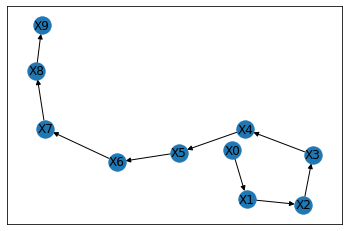

In [518]:
from random import randint, choice

M2 = PDG()
Xs = [Var.alph("X%d"%i, randint(2,3)) for i in range(10)]

var_subsets = []

for i in range(1,10):
    src = Xs[i-1];  tgt = Xs[i]
    M2 += CPT.make_random(src,tgt)
    
    var_subsets.append([src.name, tgt.name])

M2.draw()

In [535]:
ip.cvx_opt(M2, var_subsets)

For edge p19: X0 → X1, in cluster  ['X0', 'X1'] idxs_XY = [0, 1]
For edge p20: X1 → X2, in cluster  ['X1', 'X2'] idxs_XY = [0, 1]
For edge p21: X2 → X3, in cluster  ['X2', 'X3'] idxs_XY = [0, 1]
For edge p22: X3 → X4, in cluster  ['X3', 'X4'] idxs_XY = [0, 1]
For edge p23: X4 → X5, in cluster  ['X4', 'X5'] idxs_XY = [0, 1]
For edge p24: X5 → X6, in cluster  ['X5', 'X6'] idxs_XY = [0, 1]
For edge p25: X6 → X7, in cluster  ['X6', 'X7'] idxs_XY = [0, 1]
For edge p26: X7 → X8, in cluster  ['X7', 'X8'] idxs_XY = [0, 1]
For edge p27: X8 → X9, in cluster  ['X8', 'X9'] idxs_XY = [0, 1]
-2.2235667253725938e-10


ClusterPseudomarginals(marginals=[RJD Δ(X0; X1) as ndarray⟨3,3⟩, RJD Δ(X1; X2) as ndarray⟨3,3⟩, RJD Δ(X2; X3) as ndarray⟨3,3⟩, RJD Δ(X3; X4) as ndarray⟨3,3⟩, RJD Δ(X4; X5) as ndarray⟨3,2⟩, RJD Δ(X5; X6) as ndarray⟨2,2⟩, RJD Δ(X6; X7) as ndarray⟨2,2⟩, RJD Δ(X7; X8) as ndarray⟨2,3⟩, RJD Δ(X8; X9) as ndarray⟨3,3⟩], value=-2.2235667253725938e-10)

In [538]:
_535.marginals[0][Xs[1]] - _535.marginals[1][Xs[1]] # this is a good sign.

,x10,x11,x12
⋆,0.0,0.0,0.0


In [532]:
M2

[Var X0 {'x00', 'x01', 'x02'},
 Var X1 {'x10', 'x11', 'x12'},
 Var X2 {'x20', 'x21', 'x22'},
 Var X3 {'x30', 'x31', 'x32'},
 Var X4 {'x40', 'x41', 'x42'},
 Var X5 {'x50', 'x51'},
 Var X6 {'x60', 'x61'},
 Var X7 {'x70', 'x71'},
 Var X8 {'x80', 'x81', 'x82'},
 Var X9 {'x90', 'x91', 'x92'}]

# EXAMPLE: Using $\alpha$ to ensure causal picture

Let's start by doing something that requires $\alpha$'s. The classic example is two coins + A & B, and a cpd $p(C|AB)$ that is unif when $A = B$ and deterministic otherwise. Then we need $\alpha$'s to make sure that $A$ and $B$ are independent. 

In [6]:
M = PDG()

A = Var.alph("A",2)
B = Var.alph("B",2)
C = Var.alph("C",8)

M += A,B,C

M += "coin-A", CPT.from_matrix(Unit, A, np.array([0.5, 0.5]).reshape(1,2))
M += "coin-B", CPT.from_matrix(Unit, B, np.array([0.5, 0.5]).reshape(1,2))

M += "p", CPT.from_ddict(A & B, C,  
        { (a,b) : { c : 1/len(C) for c in C } if a[-1] == b[-1]
                    else  1  for (a,b) in A&B })

M['p']

c0     c1     c2     c3     c4     c5     c6     c7
a0 b0  0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125
   b1  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
a1 b0  1.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
   b1  0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125

In [49]:
from pdg.alg import interior_pt as ip

# list(M.edges("XY"))
# M._idxs( A & B )
# M.dshape

mu1 = ip.cvx_opt_joint(M, False)
mu2 = ip.cvx_opt_joint(M, True)
mu1[A,B]


,"(a0, b0)","(a0, b1)","(a1, b0)","(a1, b1)"
⋆,0.382662,0.117338,0.117338,0.382662


In [50]:
mu2 = ip.cvx_opt_joint(M)
mu2[A,B]

,"(a0, b0)","(a0, b1)","(a1, b0)","(a1, b1)"
⋆,0.249998,0.250002,0.250002,0.249998


### Now, with clusters

First litmus test: does it work if we just include one cluster? 

In [90]:
mu3 = ip.cvx_opt_clusters(M, [[V.name for V in M.varlist]], True).marginals[0]
mu3[A,B]

1.2028361083443358e-09
correction DCP?  True ... affine?  True
mult DCP? True ... affine? True
expcone?  True
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Aug 26 05:04:34 PM: Your problem has 64 variables, 5 constraints, and 0 parameters.
(CVXPY) Aug 26 05:04:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 26 05:04:34 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 26 05:04:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 26 05:04:34 PM: Compiling problem (target 

,"(a0, b0)","(a0, b1)","(a1, b0)","(a1, b1)"
⋆,0.249992,0.250008,0.250008,0.249992


Now, what if there are two clusters?

In [169]:
M2 = M.copy()

D = Var.alph("D", 3)
M2 += D
M2 += CPT.make_random(C,D)

In [186]:
# mu4 = ip.cvx_opt_clusters(M2, [["A","B","C"], ["C", "D"]], True).marginals

import cvxpy as cp
solverparams = dict(
    solver = cp.SCS,
    # mosek_params = {
    #     # 'MSK_DPAR_BASIS_TOL_X' : 1e-5,
    #     # 'MSK_DPAR_BASIS_TOL_S' : 1e-5
    # }
)

mu4F = ip.cvx_opt_clusters(M2, [["A","B","C"], ["C", "D"]], False,**solverparams).marginals
mu5F = ip.cvx_opt_clusters(M2, [["A","B","C","D"]], False,**solverparams).marginals


mu5T = ip.cvx_opt_clusters(M2, [["A","B","C","D"]], True,**solverparams).marginals
mu4T = ip.cvx_opt_clusters(M2, [["A","B","C"], ["C", "D"]], True,**solverparams).marginals


# mu6 = ip.cvx_opt_clusters(M2)

-1.2888335569348848e-05
-6.110619617506341e-09
-6.110619617506341e-09
(2, 2, 8, 3)
[[[[2.63008626e-04 1.41992196e-02 1.67877021e-02]
   [1.53486528e-02 3.65131969e-03 1.22500435e-02]
   [1.49065242e-02 1.02792182e-03 1.53155556e-02]
   [1.22900630e-02 6.42531946e-03 1.25346314e-02]
   [2.02446606e-03 1.33646167e-02 1.58609300e-02]
   [1.27188884e-02 1.42508860e-02 4.28024091e-03]
   [1.49857232e-02 1.54179931e-02 8.46282254e-04]
   [1.82119484e-03 1.62259454e-02 1.32028712e-02]]

  [[2.10407367e-03 1.13594009e-01 1.34301914e-01]
   [2.36545362e-10 5.62722182e-11 1.88791226e-10]
   [2.29538926e-10 1.58285102e-11 2.35837419e-10]
   [1.89439935e-10 9.90403466e-11 1.93209730e-10]
   [3.11905100e-11 2.05905753e-10 2.44365912e-10]
   [1.96028844e-10 2.19640633e-10 6.59688686e-11]
   [2.30719400e-10 2.37374604e-10 1.30293167e-11]
   [2.80566824e-11 2.49971166e-10 2.03398756e-10]]]


 [[[2.10407367e-03 1.13594009e-01 1.34301914e-01]
   [2.36545359e-10 5.62722175e-11 1.88791224e-10]
   [2.29538

In [164]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle([''])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [172]:
# M['p']
display_side_by_side( mu4F[0][A,B], mu4T[0][A,B])
display_side_by_side(  mu5F[0][A,B], mu5T[0][A, B])

,"(a0, b0)","(a0, b1)","(a1, b0)","(a1, b1)"
⋆,0.280771,0.219229,0.219229,0.280771
,"(a0, b0)","(a0, b1)","(a1, b0)","(a1, b1)"
⋆,0.26898,0.23102,0.23102,0.26898


,"(a0, b0)","(a0, b1)","(a1, b0)","(a1, b1)"
⋆,0.290009,0.209991,0.209991,0.290009
,"(a0, b0)","(a0, b1)","(a1, b0)","(a1, b1)"
⋆,0.249996,0.250004,0.250004,0.249996


In [183]:
ip.cvx_opt_clusters(M2, [['A', 'B','C'],['C','D']], True)

-1.4278639411088793e-09
(2, 2, 8)
[[[3.12499673e-02 3.12500077e-02 3.12500003e-02 3.12500076e-02
   3.12500056e-02 3.12500077e-02 3.12499988e-02 3.12500050e-02]
  [2.49999999e-01 9.22561521e-11 9.21818038e-11 9.22711030e-11
   9.22291599e-11 9.22615923e-11 9.21668002e-11 9.22226151e-11]]

 [[2.49999999e-01 9.22561532e-11 9.21818049e-11 9.22711041e-11
   9.22291610e-11 9.22615934e-11 9.21668010e-11 9.22226162e-11]
  [3.12499673e-02 3.12500077e-02 3.12500003e-02 3.12500076e-02
   3.12500056e-02 3.12500077e-02 3.12499988e-02 3.12500050e-02]]]

(8, 3)
[[0.00841632 0.45437599 0.5372077 ]
 [0.49115672 0.11684211 0.39200117]
 [0.47701019 0.03289048 0.49009933]
 [0.39328125 0.20561144 0.40110731]
 [0.06477851 0.42766938 0.50755211]
 [0.40700341 0.45602699 0.1369696 ]
 [0.47954452 0.4933773  0.02707818]
 [0.05827442 0.5192322  0.42249338]]



ClusterPseudomarginals(marginals=[RJD Δ(A; B; C) as ndarray⟨2,2,8⟩, RJD Δ(C; D) as ndarray⟨8,3⟩], value=-1.4278639411088793e-09)

In [184]:
M2[D|C]

,d0,d1,d2
c0,0.008416,0.454376,0.537208
c1,0.491154,0.116845,0.392001
c2,0.477011,0.032890,0.490100
c3,0.393280,0.205614,0.401106
c4,0.064779,0.427669,0.507551
c5,0.407003,0.456025,0.136973
c6,0.479545,0.493378,0.027077
c7,0.058274,0.519232,0.422494
